# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

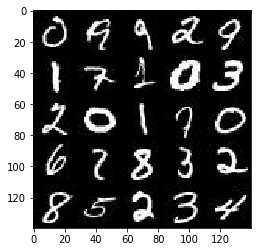

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

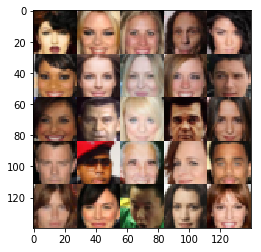

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learn_rate = tf.placeholder(tf.float32)
    

    return inputs_real, inputs_z, learn_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [36]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28X28X3
        alpha=0.2
        keep_prob = 0.9
        #print(images.get_shape())
        x1 = tf.layers.conv2d(images, 56, 5, strides=2, padding='same', activation=None)
        relu1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, keep_prob=keep_prob)
        #print(relu1.get_shape())
        # 14X14X56
        
        x2 = tf.layers.conv2d(relu1, 112, 5, strides=2, padding='same', activation=None)
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        relu2 = tf.nn.dropout(relu2, keep_prob=keep_prob)
        #print(relu2.get_shape())
        # 7x7x112
        
        x3 = tf.layers.conv2d(relu2, 224, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3 = tf.nn.dropout(relu3, keep_prob=keep_prob)
        # 4x4x224

        # Flatten it
        #print(relu3.get_shape())
        #print(relu3.get_shape()[1])
        flat = tf.reshape(relu3, (-1,4*4*224))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [35]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        alpha=0.2
        keep_prob = 0.9
        x1 = tf.layers.dense(z, 3*3*448)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 3, 3, 448))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, keep_prob=keep_prob)
        #print(x1.get_shape())
        # 3x3x448 now
        
        x2 = tf.layers.conv2d_transpose(x1, 224, 5, strides=1, padding='valid', activation=None)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #print(x2.get_shape())
        # 7x7x224 now
        
        x3 = tf.layers.conv2d_transpose(x2, 112, 3, strides=2, padding='same', activation=None)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #print(x3.get_shape())
        # 14x14x112 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=2, padding='same', activation=None)
        # 28x28x3 now
        #print(logits.get_shape())
        out = tf.tanh(logits)
        #print(out.get_shape())
        
    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [19]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):   
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [33]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #tf.reset_default_graph()
    # Create our input placeholders
    if(data_image_mode=="RGB"):
        channel=3
    else:
        channel=1
   
    input_real, input_z, learn_rate = model_inputs(data_shape[1],data_shape[2],channel, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channel)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(50, z_dim))

    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z,input_real: batch_images, learn_rate:learning_rate})

                if steps == 1:
                    print('initial output:')
                    show_generator_output(sess, 16, input_z, channel, data_image_mode)
                    
                if steps % 20 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_real: batch_images,input_z: batch_z})
                    #sess.run(d_loss, {input_real: batch_images,input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    #train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    #train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess,16, input_z, channel, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

initial output:


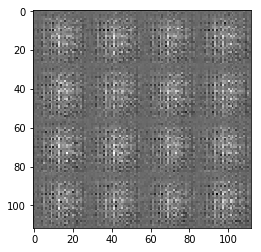

Epoch 1/2... Discriminator Loss: 0.0527... Generator Loss: 10.7559
Epoch 1/2... Discriminator Loss: 3.2353... Generator Loss: 0.0759
Epoch 1/2... Discriminator Loss: 0.9493... Generator Loss: 0.6347
Epoch 1/2... Discriminator Loss: 2.4980... Generator Loss: 0.1505
Epoch 1/2... Discriminator Loss: 1.7050... Generator Loss: 0.3270


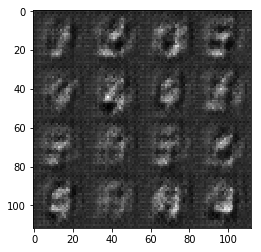

Epoch 1/2... Discriminator Loss: 1.3703... Generator Loss: 0.4374
Epoch 1/2... Discriminator Loss: 1.3277... Generator Loss: 0.4795
Epoch 1/2... Discriminator Loss: 1.2830... Generator Loss: 0.5392
Epoch 1/2... Discriminator Loss: 1.4282... Generator Loss: 0.3881
Epoch 1/2... Discriminator Loss: 1.2240... Generator Loss: 0.5226


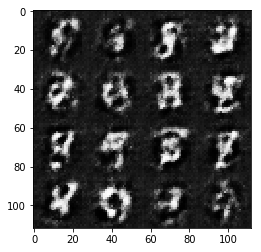

Epoch 1/2... Discriminator Loss: 1.3627... Generator Loss: 0.3735
Epoch 1/2... Discriminator Loss: 1.1789... Generator Loss: 0.5081
Epoch 1/2... Discriminator Loss: 1.2053... Generator Loss: 0.5007
Epoch 1/2... Discriminator Loss: 1.2866... Generator Loss: 0.4863
Epoch 1/2... Discriminator Loss: 1.2464... Generator Loss: 0.4287


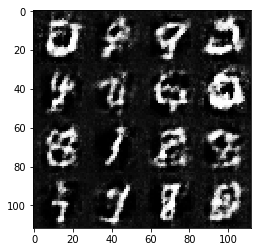

Epoch 1/2... Discriminator Loss: 1.1658... Generator Loss: 0.5569
Epoch 1/2... Discriminator Loss: 1.3677... Generator Loss: 0.4045
Epoch 1/2... Discriminator Loss: 1.4950... Generator Loss: 0.3355
Epoch 1/2... Discriminator Loss: 1.3436... Generator Loss: 0.4073
Epoch 1/2... Discriminator Loss: 1.3922... Generator Loss: 0.3847


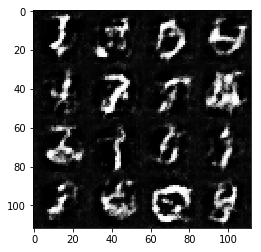

Epoch 1/2... Discriminator Loss: 1.3658... Generator Loss: 0.4377
Epoch 1/2... Discriminator Loss: 1.5870... Generator Loss: 0.2977
Epoch 1/2... Discriminator Loss: 1.0330... Generator Loss: 0.7262
Epoch 2/2... Discriminator Loss: 1.3195... Generator Loss: 0.4243
Epoch 2/2... Discriminator Loss: 1.0637... Generator Loss: 0.9481


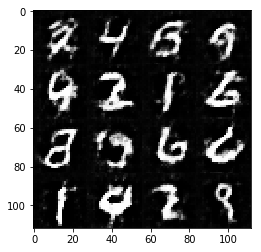

Epoch 2/2... Discriminator Loss: 1.1485... Generator Loss: 0.5708
Epoch 2/2... Discriminator Loss: 1.0465... Generator Loss: 0.7609
Epoch 2/2... Discriminator Loss: 1.0865... Generator Loss: 0.6405
Epoch 2/2... Discriminator Loss: 1.1814... Generator Loss: 0.5189
Epoch 2/2... Discriminator Loss: 1.2215... Generator Loss: 0.5262


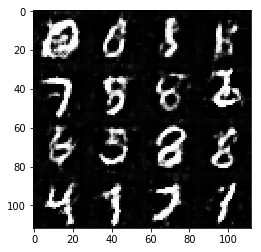

Epoch 2/2... Discriminator Loss: 1.0947... Generator Loss: 0.6920
Epoch 2/2... Discriminator Loss: 1.0954... Generator Loss: 0.7096
Epoch 2/2... Discriminator Loss: 1.2441... Generator Loss: 0.5204
Epoch 2/2... Discriminator Loss: 1.7863... Generator Loss: 2.4355
Epoch 2/2... Discriminator Loss: 1.5095... Generator Loss: 1.8971


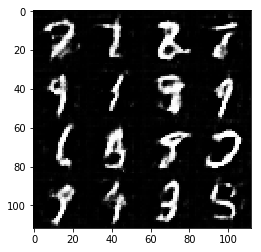

Epoch 2/2... Discriminator Loss: 1.1138... Generator Loss: 1.3899
Epoch 2/2... Discriminator Loss: 1.0260... Generator Loss: 1.0401
Epoch 2/2... Discriminator Loss: 1.1621... Generator Loss: 0.6786
Epoch 2/2... Discriminator Loss: 1.2244... Generator Loss: 1.4684
Epoch 2/2... Discriminator Loss: 1.7871... Generator Loss: 2.3284


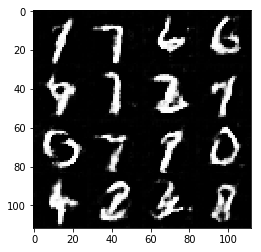

Epoch 2/2... Discriminator Loss: 1.2985... Generator Loss: 1.6332
Epoch 2/2... Discriminator Loss: 1.1663... Generator Loss: 1.5715
Epoch 2/2... Discriminator Loss: 1.4724... Generator Loss: 1.6692
Epoch 2/2... Discriminator Loss: 1.1693... Generator Loss: 1.3560
Epoch 2/2... Discriminator Loss: 1.3955... Generator Loss: 1.7884


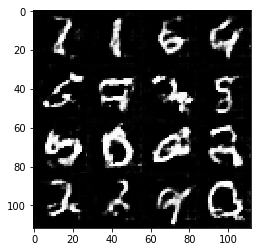

Epoch 2/2... Discriminator Loss: 1.2005... Generator Loss: 0.4908


In [39]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches, mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

initial output:


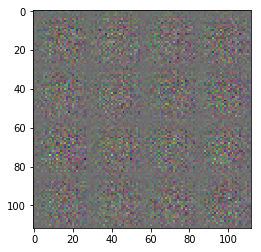

Epoch 1/2... Discriminator Loss: 1.3196... Generator Loss: 4.2590
Epoch 1/2... Discriminator Loss: 1.4381... Generator Loss: 5.1601
Epoch 1/2... Discriminator Loss: 1.5574... Generator Loss: 0.3590
Epoch 1/2... Discriminator Loss: 0.5505... Generator Loss: 1.8370
Epoch 1/2... Discriminator Loss: 0.4634... Generator Loss: 1.8433


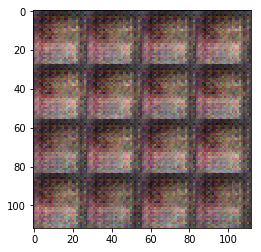

Epoch 1/2... Discriminator Loss: 0.3420... Generator Loss: 2.2023
Epoch 1/2... Discriminator Loss: 1.2115... Generator Loss: 0.5302
Epoch 1/2... Discriminator Loss: 0.9806... Generator Loss: 1.1168
Epoch 1/2... Discriminator Loss: 1.0540... Generator Loss: 0.7600
Epoch 1/2... Discriminator Loss: 1.1548... Generator Loss: 0.6258


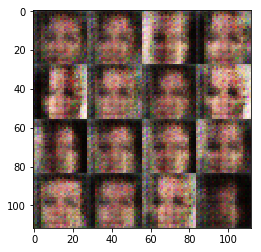

Epoch 1/2... Discriminator Loss: 0.7929... Generator Loss: 2.0040
Epoch 1/2... Discriminator Loss: 1.0796... Generator Loss: 0.6727
Epoch 1/2... Discriminator Loss: 1.1951... Generator Loss: 0.5685
Epoch 1/2... Discriminator Loss: 0.8419... Generator Loss: 1.0819
Epoch 1/2... Discriminator Loss: 1.1602... Generator Loss: 0.6624


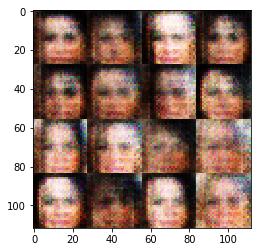

Epoch 1/2... Discriminator Loss: 1.2581... Generator Loss: 0.8643
Epoch 1/2... Discriminator Loss: 1.1526... Generator Loss: 1.3342
Epoch 1/2... Discriminator Loss: 1.0321... Generator Loss: 1.4258
Epoch 1/2... Discriminator Loss: 1.0763... Generator Loss: 0.7145
Epoch 1/2... Discriminator Loss: 1.5893... Generator Loss: 0.3252


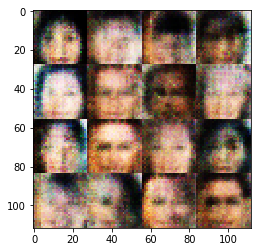

Epoch 1/2... Discriminator Loss: 1.0898... Generator Loss: 0.7735
Epoch 1/2... Discriminator Loss: 1.3459... Generator Loss: 1.8220
Epoch 1/2... Discriminator Loss: 0.9720... Generator Loss: 1.2219
Epoch 1/2... Discriminator Loss: 1.2392... Generator Loss: 0.9048
Epoch 1/2... Discriminator Loss: 1.3097... Generator Loss: 1.7770


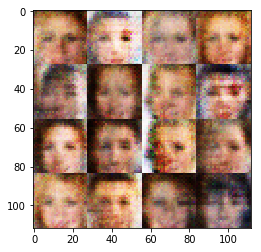

Epoch 1/2... Discriminator Loss: 1.2573... Generator Loss: 1.1267
Epoch 1/2... Discriminator Loss: 1.2963... Generator Loss: 1.2185
Epoch 1/2... Discriminator Loss: 1.2133... Generator Loss: 1.2548
Epoch 1/2... Discriminator Loss: 1.4397... Generator Loss: 0.3864
Epoch 1/2... Discriminator Loss: 1.4379... Generator Loss: 1.5194


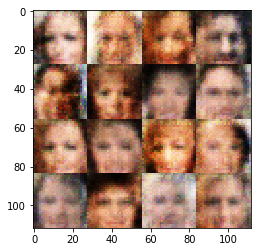

Epoch 1/2... Discriminator Loss: 1.2824... Generator Loss: 1.1505
Epoch 1/2... Discriminator Loss: 1.2233... Generator Loss: 1.0691
Epoch 1/2... Discriminator Loss: 1.3182... Generator Loss: 0.5523
Epoch 1/2... Discriminator Loss: 1.2788... Generator Loss: 1.2367
Epoch 1/2... Discriminator Loss: 1.3450... Generator Loss: 1.3276


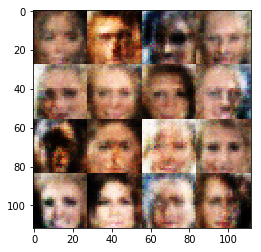

Epoch 1/2... Discriminator Loss: 1.1620... Generator Loss: 1.1006
Epoch 1/2... Discriminator Loss: 1.3126... Generator Loss: 1.1483
Epoch 1/2... Discriminator Loss: 1.1822... Generator Loss: 0.8566
Epoch 1/2... Discriminator Loss: 1.4688... Generator Loss: 0.3833
Epoch 1/2... Discriminator Loss: 1.1921... Generator Loss: 0.7420


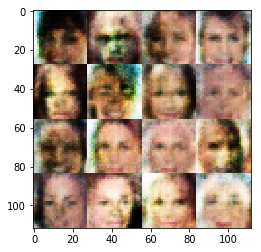

Epoch 1/2... Discriminator Loss: 1.3405... Generator Loss: 1.1318
Epoch 1/2... Discriminator Loss: 1.5109... Generator Loss: 1.5663
Epoch 1/2... Discriminator Loss: 1.3685... Generator Loss: 1.2682
Epoch 1/2... Discriminator Loss: 1.2633... Generator Loss: 0.7627
Epoch 1/2... Discriminator Loss: 1.2515... Generator Loss: 0.5588


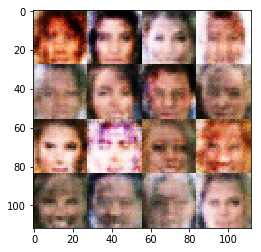

Epoch 1/2... Discriminator Loss: 1.2640... Generator Loss: 0.5811
Epoch 1/2... Discriminator Loss: 1.2927... Generator Loss: 0.7569
Epoch 1/2... Discriminator Loss: 1.2463... Generator Loss: 0.6406
Epoch 1/2... Discriminator Loss: 1.2928... Generator Loss: 1.1516
Epoch 1/2... Discriminator Loss: 1.2567... Generator Loss: 0.8969


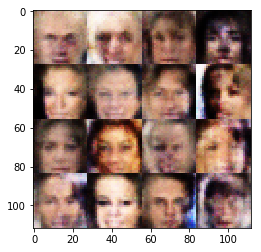

Epoch 1/2... Discriminator Loss: 1.1969... Generator Loss: 0.7923
Epoch 1/2... Discriminator Loss: 1.4030... Generator Loss: 1.6284
Epoch 1/2... Discriminator Loss: 1.2192... Generator Loss: 0.9973
Epoch 1/2... Discriminator Loss: 1.1360... Generator Loss: 0.7137
Epoch 1/2... Discriminator Loss: 1.4334... Generator Loss: 1.2205


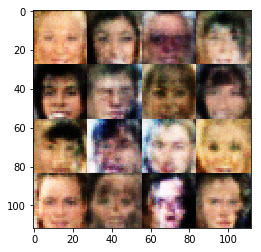

Epoch 1/2... Discriminator Loss: 1.5936... Generator Loss: 1.5181
Epoch 1/2... Discriminator Loss: 1.2827... Generator Loss: 1.0456
Epoch 1/2... Discriminator Loss: 1.4083... Generator Loss: 0.4496
Epoch 1/2... Discriminator Loss: 1.2314... Generator Loss: 0.6130
Epoch 1/2... Discriminator Loss: 1.2512... Generator Loss: 0.5958


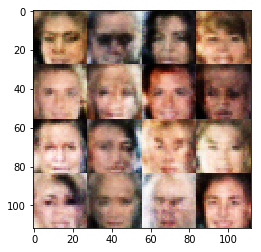

Epoch 1/2... Discriminator Loss: 1.1476... Generator Loss: 1.1200
Epoch 1/2... Discriminator Loss: 1.7970... Generator Loss: 1.9843
Epoch 1/2... Discriminator Loss: 1.2010... Generator Loss: 0.6789
Epoch 1/2... Discriminator Loss: 1.1653... Generator Loss: 0.8609
Epoch 1/2... Discriminator Loss: 1.2901... Generator Loss: 0.9574


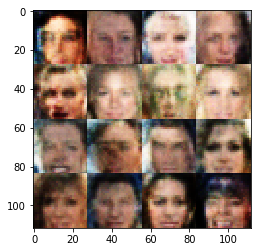

Epoch 1/2... Discriminator Loss: 1.2643... Generator Loss: 0.6184
Epoch 1/2... Discriminator Loss: 1.2372... Generator Loss: 0.7337
Epoch 1/2... Discriminator Loss: 1.1143... Generator Loss: 1.3888
Epoch 1/2... Discriminator Loss: 1.0650... Generator Loss: 1.2764
Epoch 1/2... Discriminator Loss: 1.3629... Generator Loss: 0.4669


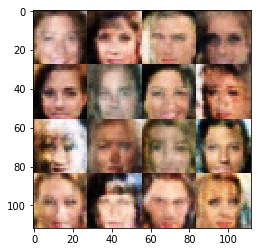

Epoch 1/2... Discriminator Loss: 1.0816... Generator Loss: 0.6812
Epoch 1/2... Discriminator Loss: 1.1886... Generator Loss: 1.3493
Epoch 1/2... Discriminator Loss: 1.1977... Generator Loss: 0.6138
Epoch 1/2... Discriminator Loss: 1.4513... Generator Loss: 0.4006
Epoch 1/2... Discriminator Loss: 1.4660... Generator Loss: 0.4175


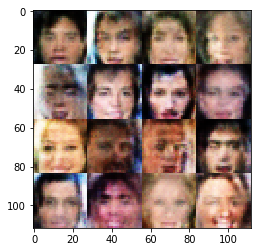

Epoch 1/2... Discriminator Loss: 1.2835... Generator Loss: 0.4985
Epoch 1/2... Discriminator Loss: 1.3672... Generator Loss: 0.7182
Epoch 1/2... Discriminator Loss: 1.0635... Generator Loss: 1.8754
Epoch 1/2... Discriminator Loss: 1.0124... Generator Loss: 2.1560
Epoch 2/2... Discriminator Loss: 1.0228... Generator Loss: 3.2270


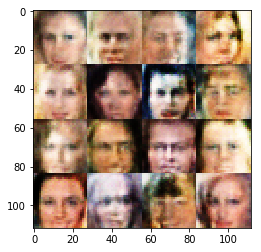

Epoch 2/2... Discriminator Loss: 1.1329... Generator Loss: 2.3167
Epoch 2/2... Discriminator Loss: 0.9167... Generator Loss: 0.8436
Epoch 2/2... Discriminator Loss: 1.4531... Generator Loss: 0.3474
Epoch 2/2... Discriminator Loss: 1.1489... Generator Loss: 0.5465
Epoch 2/2... Discriminator Loss: 1.2741... Generator Loss: 0.4175


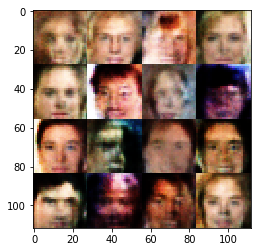

Epoch 2/2... Discriminator Loss: 1.5873... Generator Loss: 0.2770
Epoch 2/2... Discriminator Loss: 0.7752... Generator Loss: 0.8484
Epoch 2/2... Discriminator Loss: 0.2920... Generator Loss: 2.0574
Epoch 2/2... Discriminator Loss: 0.5493... Generator Loss: 2.1655
Epoch 2/2... Discriminator Loss: 1.8552... Generator Loss: 0.2313


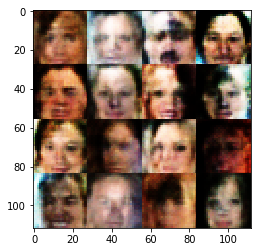

Epoch 2/2... Discriminator Loss: 0.5526... Generator Loss: 1.1980
Epoch 2/2... Discriminator Loss: 1.0041... Generator Loss: 0.6091
Epoch 2/2... Discriminator Loss: 0.9759... Generator Loss: 0.5820
Epoch 2/2... Discriminator Loss: 0.4617... Generator Loss: 1.3547
Epoch 2/2... Discriminator Loss: 1.4818... Generator Loss: 0.3341


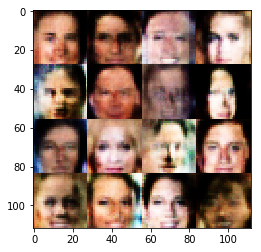

Epoch 2/2... Discriminator Loss: 0.2186... Generator Loss: 2.9559
Epoch 2/2... Discriminator Loss: 2.1400... Generator Loss: 3.4990
Epoch 2/2... Discriminator Loss: 0.5899... Generator Loss: 2.9261
Epoch 2/2... Discriminator Loss: 0.4628... Generator Loss: 4.5360
Epoch 2/2... Discriminator Loss: 0.8914... Generator Loss: 4.8637


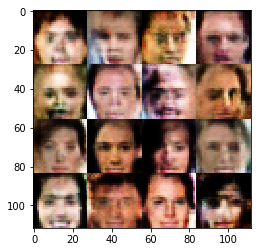

Epoch 2/2... Discriminator Loss: 0.7742... Generator Loss: 0.8540
Epoch 2/2... Discriminator Loss: 0.7046... Generator Loss: 5.0039
Epoch 2/2... Discriminator Loss: 0.4707... Generator Loss: 1.3897
Epoch 2/2... Discriminator Loss: 0.3405... Generator Loss: 3.2126
Epoch 2/2... Discriminator Loss: 0.4020... Generator Loss: 1.4178


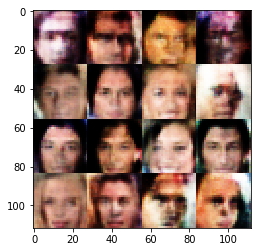

Epoch 2/2... Discriminator Loss: 0.3848... Generator Loss: 1.8919
Epoch 2/2... Discriminator Loss: 0.5326... Generator Loss: 4.8689
Epoch 2/2... Discriminator Loss: 0.3574... Generator Loss: 1.6079
Epoch 2/2... Discriminator Loss: 0.3116... Generator Loss: 4.9845
Epoch 2/2... Discriminator Loss: 0.4688... Generator Loss: 2.0506


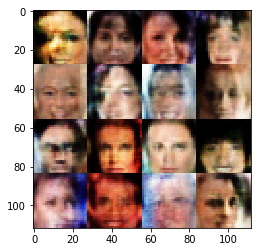

Epoch 2/2... Discriminator Loss: 0.4065... Generator Loss: 1.8868
Epoch 2/2... Discriminator Loss: 0.3199... Generator Loss: 1.7584
Epoch 2/2... Discriminator Loss: 0.3041... Generator Loss: 2.0649
Epoch 2/2... Discriminator Loss: 0.4474... Generator Loss: 3.9938
Epoch 2/2... Discriminator Loss: 0.7670... Generator Loss: 0.9061


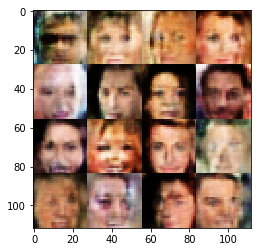

Epoch 2/2... Discriminator Loss: 0.7342... Generator Loss: 0.8744
Epoch 2/2... Discriminator Loss: 0.4929... Generator Loss: 2.3358
Epoch 2/2... Discriminator Loss: 0.3297... Generator Loss: 3.1888
Epoch 2/2... Discriminator Loss: 1.3641... Generator Loss: 0.4336
Epoch 2/2... Discriminator Loss: 0.5783... Generator Loss: 2.3209


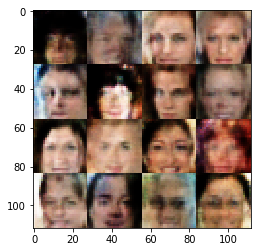

Epoch 2/2... Discriminator Loss: 0.5299... Generator Loss: 1.3136
Epoch 2/2... Discriminator Loss: 0.4356... Generator Loss: 1.4338
Epoch 2/2... Discriminator Loss: 1.0082... Generator Loss: 0.6356
Epoch 2/2... Discriminator Loss: 0.6556... Generator Loss: 1.1315
Epoch 2/2... Discriminator Loss: 0.4869... Generator Loss: 3.6748


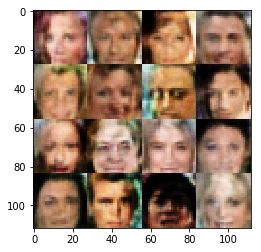

Epoch 2/2... Discriminator Loss: 0.8042... Generator Loss: 3.1134
Epoch 2/2... Discriminator Loss: 1.0610... Generator Loss: 3.2163
Epoch 2/2... Discriminator Loss: 0.4023... Generator Loss: 2.0072
Epoch 2/2... Discriminator Loss: 0.4952... Generator Loss: 1.3037
Epoch 2/2... Discriminator Loss: 0.2888... Generator Loss: 2.0034


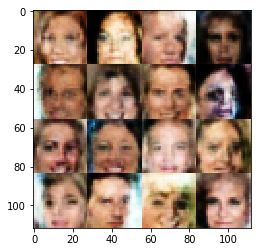

Epoch 2/2... Discriminator Loss: 1.6064... Generator Loss: 0.3135
Epoch 2/2... Discriminator Loss: 0.5892... Generator Loss: 1.5259
Epoch 2/2... Discriminator Loss: 0.9665... Generator Loss: 0.6921
Epoch 2/2... Discriminator Loss: 0.5005... Generator Loss: 3.7288
Epoch 2/2... Discriminator Loss: 0.4972... Generator Loss: 1.6897


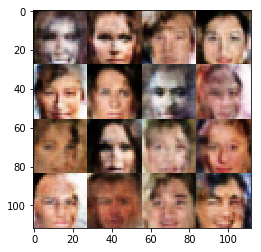

Epoch 2/2... Discriminator Loss: 1.3436... Generator Loss: 0.4375
Epoch 2/2... Discriminator Loss: 0.4798... Generator Loss: 2.3273
Epoch 2/2... Discriminator Loss: 0.4520... Generator Loss: 1.5641
Epoch 2/2... Discriminator Loss: 2.1281... Generator Loss: 0.1949
Epoch 2/2... Discriminator Loss: 0.5626... Generator Loss: 1.9123


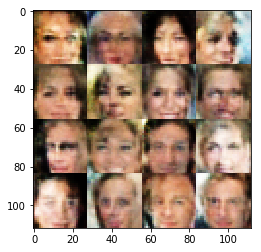

Epoch 2/2... Discriminator Loss: 0.2533... Generator Loss: 3.2806
Epoch 2/2... Discriminator Loss: 0.5631... Generator Loss: 1.9691
Epoch 2/2... Discriminator Loss: 0.5322... Generator Loss: 1.4178
Epoch 2/2... Discriminator Loss: 0.5409... Generator Loss: 1.6362
Epoch 2/2... Discriminator Loss: 2.4050... Generator Loss: 3.1785


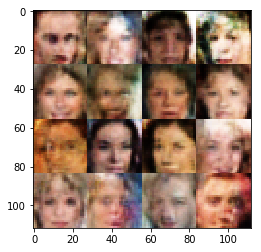

Epoch 2/2... Discriminator Loss: 0.5366... Generator Loss: 1.5215
Epoch 2/2... Discriminator Loss: 0.4532... Generator Loss: 2.0066
Epoch 2/2... Discriminator Loss: 0.4014... Generator Loss: 2.7398
Epoch 2/2... Discriminator Loss: 0.4294... Generator Loss: 1.8466
Epoch 2/2... Discriminator Loss: 0.8312... Generator Loss: 0.6771


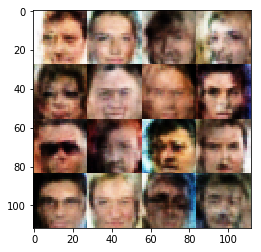

Epoch 2/2... Discriminator Loss: 1.7526... Generator Loss: 0.2540
Epoch 2/2... Discriminator Loss: 0.3149... Generator Loss: 3.2249
Epoch 2/2... Discriminator Loss: 0.2621... Generator Loss: 2.4568
Epoch 2/2... Discriminator Loss: 0.7157... Generator Loss: 3.0876
Epoch 2/2... Discriminator Loss: 0.4824... Generator Loss: 1.4672


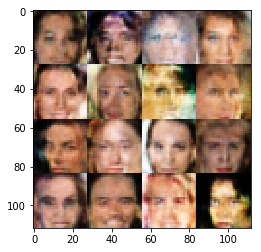

Epoch 2/2... Discriminator Loss: 0.2961... Generator Loss: 2.0013
Epoch 2/2... Discriminator Loss: 0.5873... Generator Loss: 1.1349
Epoch 2/2... Discriminator Loss: 2.1662... Generator Loss: 0.1940


In [38]:
batch_size = 128
z_dim = 100
learning_rate = .0002
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.